In [1]:
from matplotlib import pyplot as plt
import numpy as np

from sigproc_kit import *

from my_utils import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = 10*prop_cycle.by_key()['color']

In [2]:
t = np.arange(0.,10.5e-9,2.5e-12)

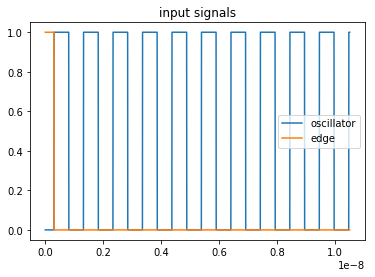

In [3]:
# just an example plot


osc_freq=983.56e6

hit_time = 300e-12 

edge = t < hit_time

#osc  = sqwave(2*np.pi*(t-hit_time)*osc_freq)>0

duty_cycle = 0.5

asym_thr = 1-2*duty_cycle

osc = invrampwave(2*np.pi*(t-hit_time)*osc_freq) > asym_thr

plt.plot(t,osc,label="oscillator")
plt.plot(t,edge,label="edge")
plt.legend()
plt.title("input signals")
plt.show()

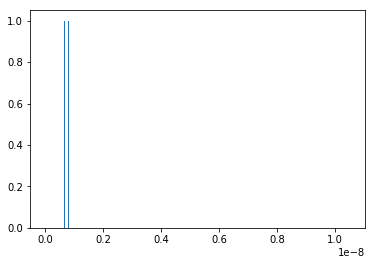

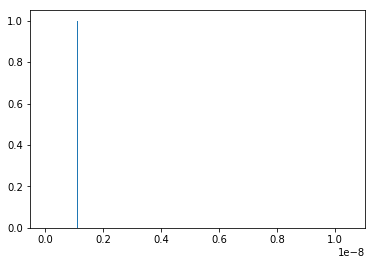

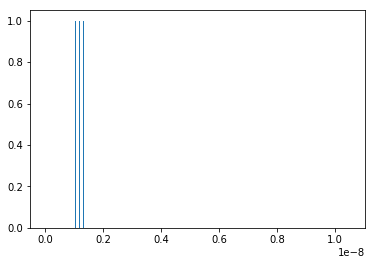

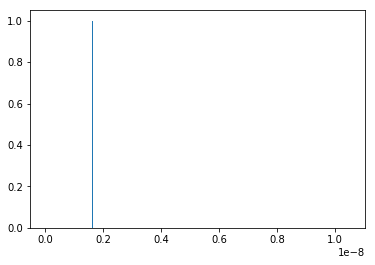

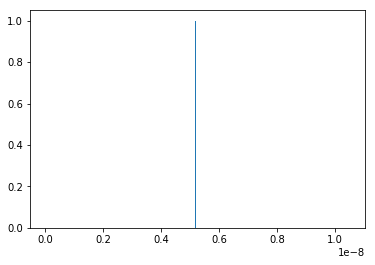

In [4]:

# window width 500p
# offset 250p
tdl_points_I = np.arange(0.5e-9,1e-9,20e-12)
Q_offset = 0.25e-9
#Q_offset = 0.35e-9
tdl_points_Q = np.arange(Q_offset+0.5e-9,Q_offset+1e-9,20e-12)

tdl_points_Ib = np.arange(1e-9,1.5e-9,20e-12)
Q_offset = 0.25e-9
#Q_offset = 0.35e-9
tdl_points_Qb = np.arange(Q_offset+1.0e-9,Q_offset+1.5e-9,20e-12)

inter_sigma = 0e-12
tdl_points_intermediate = np.linspace(0,11e-9,20) + 11e-9/20
tdl_points_intermediate += inter_sigma*np.random.randn(len(tdl_points_intermediate))

tdl_hist_I = plt.hist(tdl_points_I,bins=t)
plt.show()
tdl_hist_Q = plt.hist(tdl_points_Q,bins=t)
plt.show()
tdl_hist_Ib = plt.hist(tdl_points_Ib,bins=t)
plt.show()
tdl_hist_Qb = plt.hist(tdl_points_Qb,bins=t)
plt.show()
tdl_hist_intermediate = plt.hist(tdl_points_intermediate,bins=t)
plt.show()

I_loc = np.append(tdl_hist_I[0],[0])
Q_loc = np.append(tdl_hist_Q[0],[0])
Ib_loc = np.append(tdl_hist_Ib[0],[0])
Qb_loc = np.append(tdl_hist_Qb[0],[0])
intermediate_loc = np.append(tdl_hist_intermediate[0],[0])

In [29]:
def TDC_action(ht):
    osc = invrampwave(2*np.pi*(t-ht)*osc_freq) > asym_thr
    edge = t < ht
    Ia = np.dot(I_loc,osc)
    Qa = np.dot(Q_loc,osc)
    Ib = np.dot(Ib_loc,osc)
    Qb = np.dot(Qb_loc,osc)
    I = Ia-Ib
    Q = Qa-Qb
    
    # jitter on itime measurement
    itime_edge = t < (ht+ 50e-12*np.random.normal())
    itime = np.dot(intermediate_loc,itime_edge)
    phi = np.arctan2(Q,I)
    return (itime,phi)

In [30]:
N = 100000

hts = 10e-9*np.random.random(N)

itime = np.array([])
phi   = np.array([])

for ht in hts:
    my_itime, my_phi = TDC_action(ht)
    itime = np.append(itime,[my_itime])
    phi   = np.append(phi,[my_phi])
    

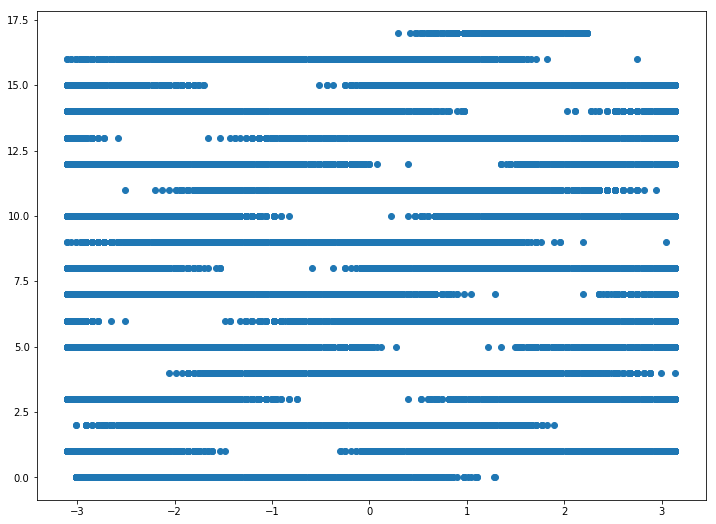

In [31]:
plt.scatter(phi,itime)

In [32]:

# Function to format ticks as multiples of π
def format_ticks(val, pos):
    if val == 0:
        return '0'
    elif val == 0.5:
        return 'π/2'
    elif val == -0.5:
        return '-π/2'
    elif val == 1:
        return 'π'
    elif val == -1:
        return '-π'
    elif val == 2 * np.pi:
        return '2π'
    elif val == -2 * np.pi:
        return '-2π'
    else:
        return f'{val/np.pi:.0f}π'





def ana_rot(phi,itime,**kwargs):

    #plt.rcParams["figure.figsize"] = (5,4)
    fig, ax = plt.subplots()
    # Set major ticks at multiples of π/2
    #ax.xaxis.set_major_locator(MultipleLocator(base=0.5))
    # Apply the formatting function
    #ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.grid(True)

    
    #phi = np.arctan2(Q,I)
    
    rotations   = np.array([])
    gap_centers = np.array([])


    plot = kwargs.get("plot",False)
    
    last_gap_center = 0
    rotation = 0
    
    my_range = int(np.max(itime))+1
    
    last_start_of_block = -1000
    last_end_of_block   = -1000
    last_block_center   = -1000
    last_block_over_gap      = False
    

    for i in range(my_range):
        mask = (itime == i)
        phiset=phi[mask]
        
        
            
        gap_center = 0
            
        if len(phiset) > 0:
        
            phiset.sort()
            
            rot_phiset = np.concatenate((phiset[1:],phiset[:1])) 
            
            distance = (rot_phiset - phiset) % (2*np.pi)
            
            end_of_block = phiset[np.argmax(distance)]
            start_of_block = phiset[ (np.argmax(distance)+1) % len(phiset) ]
            max_distance  = np.max(distance)
            block_width   = 2*np.pi - max_distance
            gap_center = ((end_of_block + max_distance/2 + np.pi) % (2*np.pi)) - np.pi
            block_center = ((start_of_block + block_width/2 + np.pi) % (2*np.pi)) - np.pi
            #plt.plot(distance)
            #plt.show()
            if(0):
                print("gap distance: {}".format(max_distance))
                print("start of block: {}".format(start_of_block))
                print("end of block: {}".format(end_of_block))
                print("gap center: {}".format(gap_center))
                print("block center: {}".format(block_center))
            
            block_over_gap = block_center > gap_center
            
            #if (last_block_over_gap == False) and (block_over_gap == True):
                #rotation += 1
            if gap_center < last_gap_center:
                rotation += 1
                
            #print("counted rotations: {}".format(rotation))
            
            last_gap_center     = gap_center
            last_start_of_block = start_of_block
            last_end_of_block   = end_of_block
            last_block_center   = block_center
            last_block_over_gap = block_over_gap
            
        gap_centers = np.append(gap_centers,[gap_center])
        rotations   = np.append(rotations,[rotation])
        
        
        if(plot):
            print("i = {}".format(i))

            #ax.hist(phiset/np.pi,bins=np.arange(-1,1,.025))
            
            ax.scatter( 
                phiset/np.pi,
                np.zeros(len(phiset)) + i + 0.25*(np.random.random(len(phiset))-0.5),
                s=6,
                c=colors[i]
            )
            
            marker_size=150
            ax.scatter( 
                [gap_center/np.pi],
                [i],
                s=marker_size,
                c=colors[i],
                marker="x"
            )
            
            marker_size=300
            ax.scatter( 
                [start_of_block/np.pi],
                [i],
                s=marker_size,
                c=colors[i],
                marker="|"
            )
            ax.scatter( 
                [end_of_block/np.pi],
                [i],
                s=marker_size,
                c=colors[i],
                marker="|"
            )
            
            
            #ax.set_yticks(list(range(5)))
            
            ax.set_xticks([-1,-0.5,0,0.5,1])
            
            #plt.show()
    
    plt.savefig("gap_centers.svg")
    plt.show()
        
    #print(gap_centers)
   
    if(True):
        idx = list(range(my_range))
        plt.plot(idx,rotations)
        plt.scatter(idx,rotations,label="rotations")
        plt.plot(idx,gap_centers)
        plt.scatter(idx,gap_centers,label="gap centers")
        plt.title("unfolding analysis")
        plt.legend()
        plt.xlabel("intermediate time")
        plt.show()
        
    return (rotations,gap_centers)

def cont_phi_new(phi,itime,rotations,gap_centers):
    
    new_phi = np.zeros(len(phi))
    
    for i, phival in enumerate(phi):
        
        index = int(itime[i]) 
        if phival >= gap_centers[index]: # the lower valued part
                new_phi[i] = phival  + (rotations[index])*2*np.pi
        else: # higher valued part
                new_phi[i] = phival  + (rotations[index]+1)*2*np.pi
        
        
        
    return new_phi + np.pi

def cont_phi_gaps(phi,itime,rotations,gap_centers):
    
    new_phi = np.zeros(len(phi))
    
    for i, phival in enumerate(phi):
        
        index = int(itime[i]) 
        if phival >= gap_centers[index]: # the lower valued part
                new_phi[i] = phival  + (2*index)*2*np.pi
        else: # higher valued part
                new_phi[i] = phival  + (2*index + 1)*2*np.pi
        
        
        
    return new_phi + np.pi


def calib_ftime(cphi,calib_curve,phistep,period):
    ftime = np.zeros(len(cphi))
    
    for i, phival in enumerate(cphi):
        ftime[i] = period * calib_curve[int(phival/phistep)]
        
    return ftime

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17


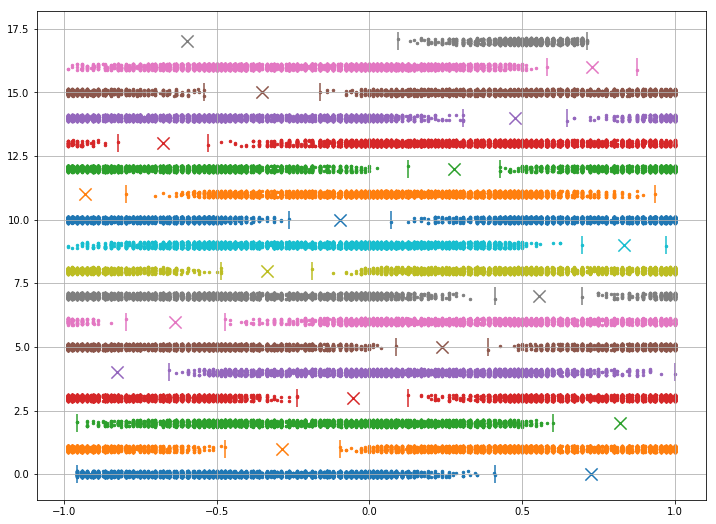

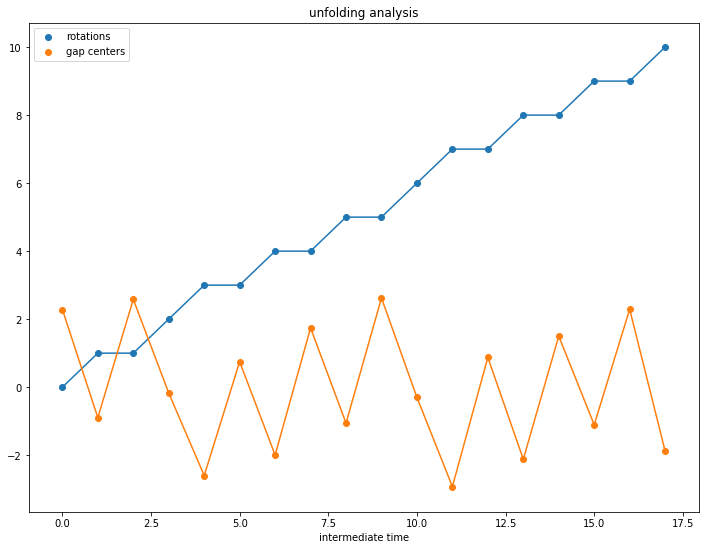

In [33]:
big_figure()
rotations, gap_centers = ana_rot(phi,itime,plot=True)

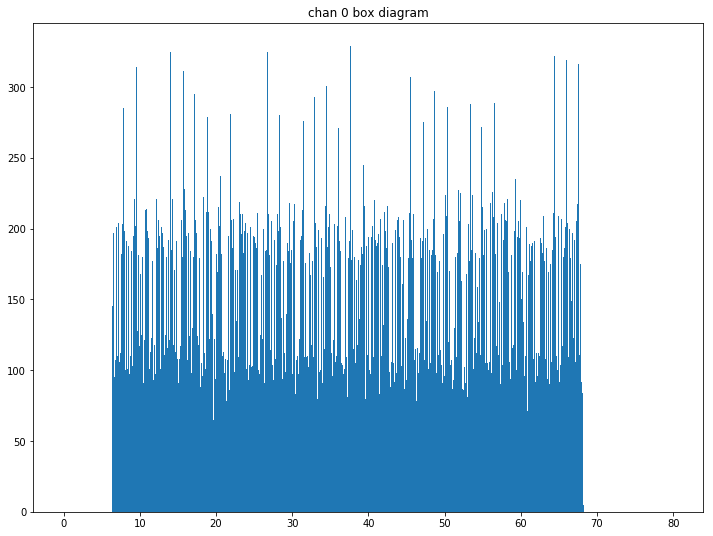

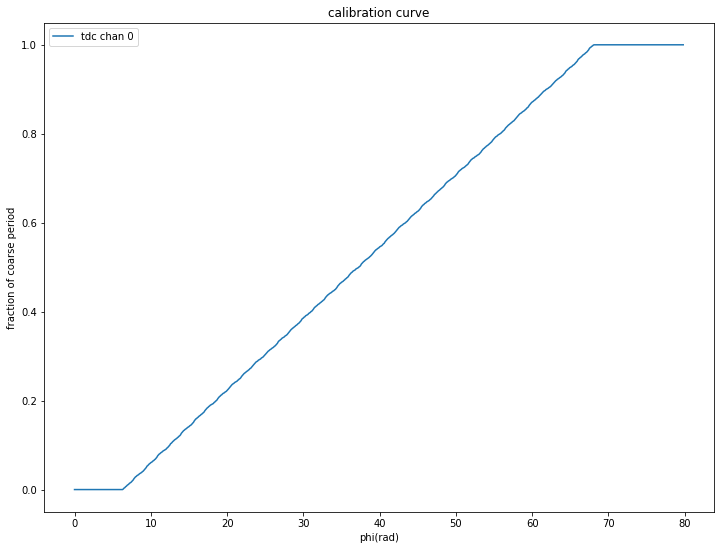

In [34]:
cphi = cont_phi_new(phi,itime,rotations,gap_centers)

period = 10e-9

phistep = 0.1

phirange = 80

hist_a = plt.hist(cphi,bins=np.arange(0,phirange,phistep))
plt.title("chan 0 box diagram")
plt.show()


calib_bins = hist_a[1][:-1]
plt.title("calibration curve")

curve_a = np.cumsum(hist_a[0])/np.sum(hist_a[0])

plt.plot(calib_bins,curve_a,label="tdc chan 0")
plt.legend()
plt.xlabel("phi(rad)")
plt.ylabel("fraction of coarse period")
plt.show()

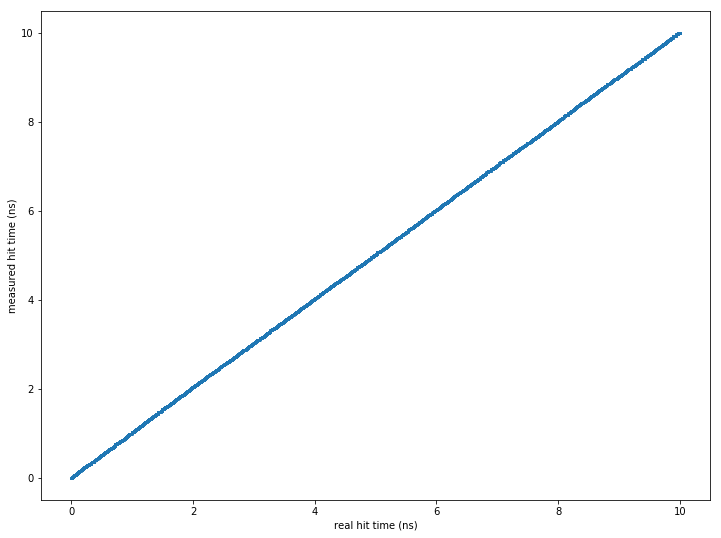

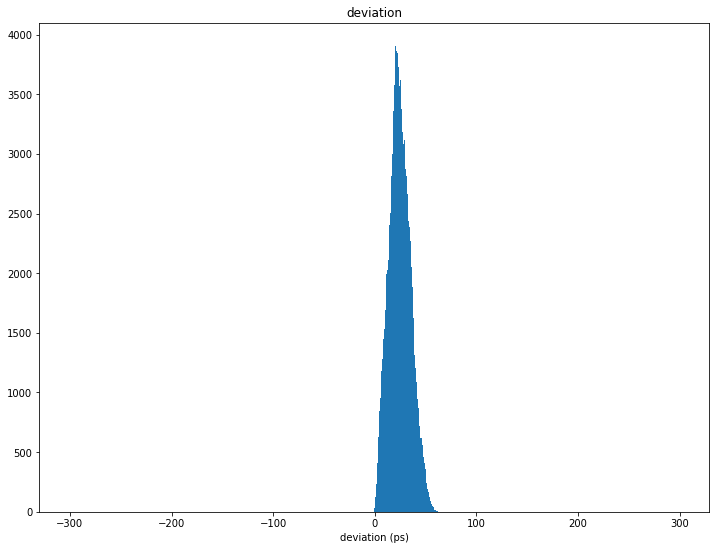

standard deviation = 10.614 ps


In [35]:
ftime_a = calib_ftime(cphi,curve_a,phistep,period)
time_a = ftime_a

plt.scatter(hts*1e9,time_a*1e9,s=1)
plt.xlabel("real hit time (ns)")
plt.ylabel("measured hit time (ns)")
plt.show()


deviation = time_a - hts

plt.hist(deviation*1e12,bins=np.arange(-300,300,1))
plt.xlabel("deviation (ps)")
plt.title("deviation")
plt.show()

print("standard deviation = {:3.3f} ps".format(1e12*np.std(deviation)))


In [ ]:
# maxi type gaps procedure

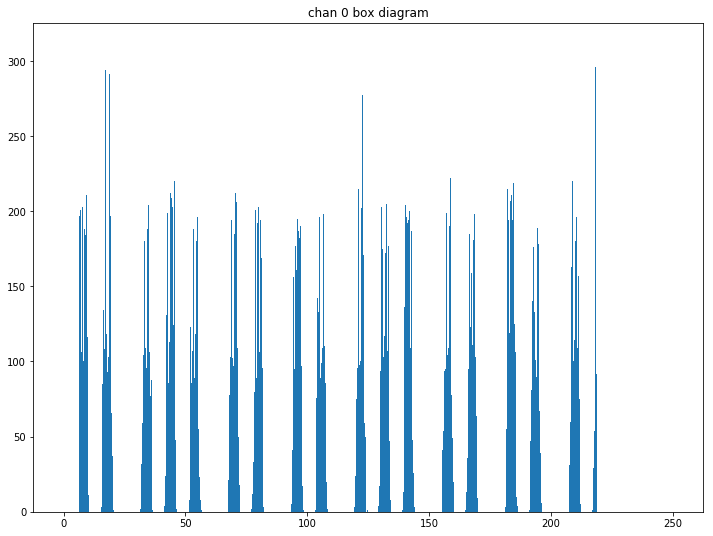

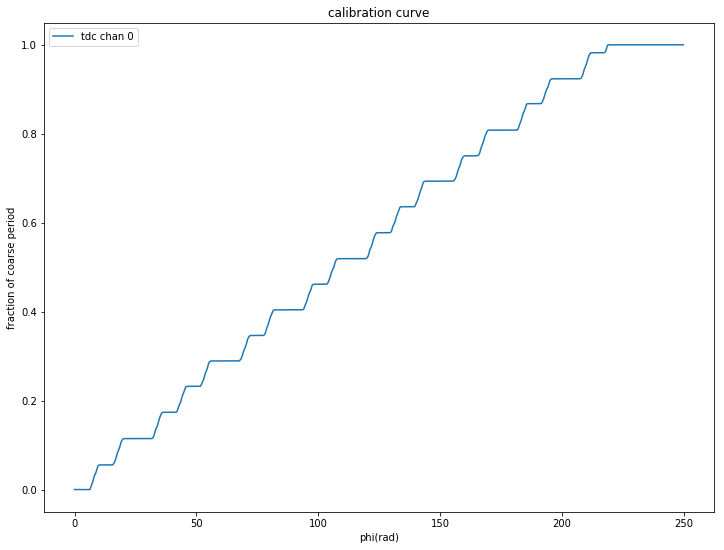

In [36]:
cphi = cont_phi_gaps(phi,itime,rotations,gap_centers)

period = 10e-9

phistep = 0.1

phirange = 250

hist_a = plt.hist(cphi,bins=np.arange(0,phirange,phistep))
plt.title("chan 0 box diagram")
plt.show()


calib_bins = hist_a[1][:-1]
plt.title("calibration curve")

curve_a = np.cumsum(hist_a[0])/np.sum(hist_a[0])

plt.plot(calib_bins,curve_a,label="tdc chan 0")
plt.legend()
plt.xlabel("phi(rad)")
plt.ylabel("fraction of coarse period")
plt.show()

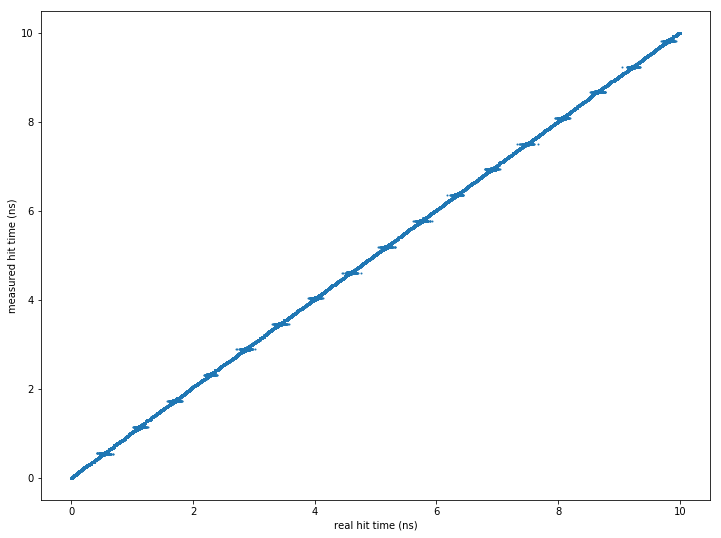

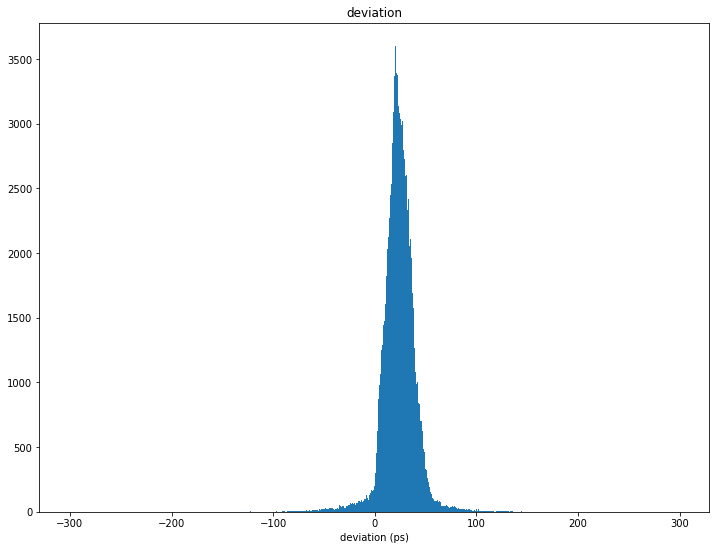

standard deviation = 16.544 ps


In [37]:
ftime_a = calib_ftime(cphi,curve_a,phistep,period)
time_a = ftime_a

plt.scatter(hts*1e9,time_a*1e9,s=1)
plt.xlabel("real hit time (ns)")
plt.ylabel("measured hit time (ns)")
plt.show()


deviation = time_a - hts

plt.hist(deviation*1e12,bins=np.arange(-300,300,1))
plt.xlabel("deviation (ps)")
plt.title("deviation")
plt.show()

print("standard deviation = {:3.3f} ps".format(1e12*np.std(deviation)))
